<a href="https://colab.research.google.com/github/avilaJorge/CSE253_FinalProject/blob/master/DeepFakeDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !rm -R ./Logistic_Regression/*
# !mkdir Linear_Regression
# !rm -R ./sample_data
# !wget https://storage.googleapis.com/img-hosting-bucket/Faces_HQ.hdf5

--2020-03-14 06:26:23--  https://storage.googleapis.com/img-hosting-bucket/Faces_HQ.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116322048 (111M) [application/octet-stream]
Saving to: ‘Faces_HQ.hdf5’

Faces_HQ.hdf5       100%[===================>] 110.93M   102MB/s    in 1.1s    

2020-03-14 06:26:25 (102 MB/s) - ‘Faces_HQ.hdf5’ saved [116322048/116322048]



In [0]:
!cp *.py /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles
!cp *.ipynb /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles

In [0]:
# !wget https://storage.googleapis.com/img-hosting-bucket/Faces_HQ.hdf5

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Mar 14 06:33:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%run DeepFake_Dataloader.py
%run utils.py

In [2]:
# imports pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Numpy, Matplotlib, and PIL
import numpy as np
import matplotlib.pyplot as plt

# K-means import
# !pip install pykeops
from pykeops.torch import LazyTensor
!pip install kmeans-pytorch
from kmeans_pytorch import kmeans

# general imports
import pprint

# My imports
from DeepFake_Dataloader import get_dataloaders
from models import LinearRegression, save_model, SVM, KMeans
from utils import RunningAverage
from train import train, evaluate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
trn_dl, val_dl, tst_dl = get_dataloaders(dataset=DeepFakeHDF5Dataset)

In [0]:
s_epoch      = 1
num_epochs   = 300
lr_rate      = 1e-2
load_model   = False
model_name   = 'LogisticRegressionModel'
path         = '/content/Logistic_Regression'

lr_model = LinearRegression(725).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=lr_rate, weight_decay=1e-3, momentum=0.9)

if load_model:
    lr_model.load_state_dict(torch.load(''))

In [5]:

train_losses, valid_losses = train(lr_model, 
                                   optimizer, 
                                   criterion, 
                                   trn_dl, 
                                   val_dl,
                                   model_name,
                                   path,
                                   predicter=torch.nn.Sigmoid())

Epoch:  1
Training loss: 0.0971


Training Loss:  0.0392
Training accuracy: 99.1208%


Validation Loss:  0.0354
Validation accuracy: 99.0750%
"Best Loss": 0.03539348080281227

Validation Loss has gone up 0 times.



Epoch:  2
Training loss: 0.0284


Training Loss:  0.0187
Training accuracy: 99.6417%


Validation Loss:  0.0156
Validation accuracy: 99.7125%
"Best Loss": 0.015631777038502086

Validation Loss has gone up 0 times.



Epoch:  3
Training loss: 0.0161


Training Loss:  0.0119
Training accuracy: 99.7667%


Validation Loss:  0.0099
Validation accuracy: 99.8375%
"Best Loss": 0.009928361261411316

Validation Loss has gone up 0 times.



Epoch:  4
Training loss: 0.0108


Training Loss:  0.008
Training accuracy: 99.8292%


Validation Loss:  0.0069
Validation accuracy: 99.8625%
"Best Loss": 0.006900007988045376

Validation Loss has gone up 0 times.



Epoch:  5
Training loss: 0.008


Training Loss:  0.0064
Training accuracy: 99.9083%


Validation Loss:  0.0057
Validation accuracy: 99.9125%
"Best Loss": 0.00569925720744308

Validation Loss has gone up 0 times.



Epoch:  6
Training loss: 0.0062


Training Loss:  0.0056
Training accuracy: 99.9083%


Validation Loss:  0.005
Validation accuracy: 99.9125%
"Best Loss": 0.0049509519622439446

Validation Loss has gone up 0 times.



Epoch:  7
Training loss: 0.0057


Training Loss:  0.0049
Training accuracy: 99.9292%


Validation Loss:  0.0043
Validation accuracy: 99.9500%
"Best Loss": 0.004308317675225672

Validation Loss has gone up 0 times.



Epoch:  8
Training loss: 0.0048


Training Loss:  0.0042
Training accuracy: 99.9375%


Validation Loss:  0.004
Validation accuracy: 99.9375%
"Best Loss": 0.004026317438628111

Validation Loss has gone up 0 times.



Epoch:  9
Training loss: 0.0047


Training Loss:  0.004
Training accuracy: 99.9375%


Validation Loss:  0.0033
Validation accuracy: 99.9375%
"Best Loss": 0.0033330763486908777

Validation Loss has gone up 0 times.



Epoch:  10
Training loss: 0.0044


Training Loss:  0.005
Training accuracy: 99.9167%


Validation Loss:  0.0041
Validation accuracy: 99.9250%
Validation Loss has gone up 1 times.



Epoch:  11
Training loss: 0.0041


Training Loss:  0.0036
Training accuracy: 99.9458%


Validation Loss:  0.0029
Validation accuracy: 99.9375%
"Best Loss": 0.002919164209050082

Validation Loss has gone up 0 times.



Epoch:  12
Training loss: 0.0038


Training Loss:  0.0033
Training accuracy: 99.9500%


Validation Loss:  0.0025
Validation accuracy: 99.9375%
"Best Loss": 0.00254628184576711

Validation Loss has gone up 0 times.



Epoch:  13
Training loss: 0.0036


Training Loss:  0.0034
Training accuracy: 99.9500%


Validation Loss:  0.0028
Validation accuracy: 99.9375%
Validation Loss has gone up 1 times.



Epoch:  14
Training loss: 0.0036


Training Loss:  0.0033
Training accuracy: 99.9583%


Validation Loss:  0.0025
Validation accuracy: 99.9625%
"Best Loss": 0.0025177830941088145

Validation Loss has gone up 0 times.



Epoch:  15
Training loss: 0.0034


Training Loss:  0.0032
Training accuracy: 99.9458%


Validation Loss:  0.0025
Validation accuracy: 99.9500%
"Best Loss": 0.0024635963805300725

Validation Loss has gone up 0 times.



Epoch:  16
Training loss: 0.0034


Training Loss:  0.0031
Training accuracy: 99.9458%


Validation Loss:  0.0023
Validation accuracy: 99.9500%
"Best Loss": 0.0023230569047247257

Validation Loss has gone up 0 times.



Epoch:  17
Training loss: 0.0037


Training Loss:  0.003
Training accuracy: 99.9542%


Validation Loss:  0.0022
Validation accuracy: 99.9500%
"Best Loss": 0.0022002405723527303

Validation Loss has gone up 0 times.



Epoch:  18
Training loss: 0.0032


Training Loss:  0.0043
Training accuracy: 99.9500%


Validation Loss:  0.0034
Validation accuracy: 99.9500%
Validation Loss has gone up 1 times.



Epoch:  19
Training loss: 0.0033


Training Loss:  0.0037
Training accuracy: 99.9542%


Validation Loss:  0.003
Validation accuracy: 99.9625%
Validation Loss has gone up 0 times.



Epoch:  20
Training loss: 0.003


Training Loss:  0.0029
Training accuracy: 99.9542%


Validation Loss:  0.0021
Validation accuracy: 99.9625%
"Best Loss": 0.0020561999759622037

Validation Loss has gone up 0 times.



Epoch:  21
Training loss: 0.0031


Training Loss:  0.0036
Training accuracy: 99.9542%


Validation Loss:  0.0026
Validation accuracy: 99.9625%
Validation Loss has gone up 1 times.



Epoch:  22
Training loss: 0.0032


Training Loss:  0.0029
Training accuracy: 99.9625%


Validation Loss:  0.0021
Validation accuracy: 99.9625%
Validation Loss has gone up 0 times.



Epoch:  23
Training loss: 0.0031


Training Loss:  0.0028
Training accuracy: 99.9583%


Validation Loss:  0.0019
Validation accuracy: 99.9750%
"Best Loss": 0.0019122106217158339

Validation Loss has gone up 0 times.



Epoch:  24
Training loss: 0.0031


Training Loss:  0.0032
Training accuracy: 99.9458%


Validation Loss:  0.0023
Validation accuracy: 99.9875%
Validation Loss has gone up 1 times.



Epoch:  25
Training loss: 0.0031


Training Loss:  0.0029
Training accuracy: 99.9583%


Validation Loss:  0.002
Validation accuracy: 99.9875%
Validation Loss has gone up 0 times.



Epoch:  26
Training loss: 0.0031


Training Loss:  0.0029
Training accuracy: 99.9667%


Validation Loss:  0.0023
Validation accuracy: 99.9625%
Validation Loss has gone up 1 times.



Epoch:  27
Training loss: 0.0029


Training Loss:  0.0034
Training accuracy: 99.9542%


Validation Loss:  0.0025
Validation accuracy: 99.9750%
Validation Loss has gone up 2 times.



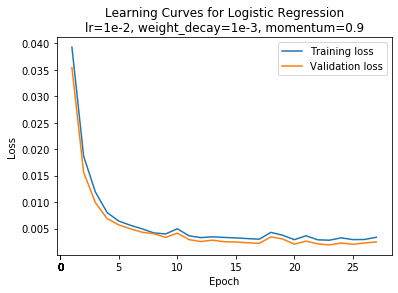

In [8]:
epochs = range(1, len(train_losses) + 1)
epoch_ticks = [i if i % 5 == 0 else 0 for i in epochs]
    
# plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, valid_losses, label='Validation loss')
plt.legend()
plt.title('Learning Curves for Logistic Regression\nlr=1e-2, weight_decay=1e-3, momentum=0.9')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.savefig('lr_train.jpg', dpi=300)
plt.show()


In [11]:
test_losses = []
evaluate(lr_model,
         optimizer,
         criterion,
         0,
         tst_dl,
         test_losses,
         "",
         "",
         acc_thresh=0.5,
         predicter=torch.nn.Sigmoid(),
         validation=False)

Validation Loss:  0.3492
Validation accuracy: 99.9250%


0.34921380830189536

In [0]:
trn_dl, val_dl, tst_dl = get_dataloaders(dataset=DeepFakeHDF5Dataset_SVM)

In [0]:
s_epoch      = 1
num_epochs   = 300
lr_rate      = 1e-2
load_model   = False
model_name   = 'SVMModel'
path         = '/content/SVM_Model'

svm_model = SVM(725).to(device)
criterion = torch.nn.SoftMarginLoss()
optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr_rate, weight_decay=1e-3, momentum=0.9)

if load_model:
    svm_model.load_state_dict(torch.load(''))

In [15]:
def svm_lbls(T):
    T[torch.nonzero((T < 0.0))] = 0
    return T

train_losses, valid_losses = train(svm_model, 
                                   optimizer, 
                                   criterion, 
                                   trn_dl, 
                                   val_dl,
                                   model_name,
                                   path,
                                   acc_thresh=0.0,
                                   label_transform=svm_lbls,
                                   predicter=nn.Tanh())

Epoch:  1
Training loss: 0.0978


Training Loss:  0.0367
Training accuracy: 98.7333%


Validation Loss:  0.0362
Validation accuracy: 98.7125%
"Best Loss": 0.036177474029717

Validation Loss has gone up 0 times.



Epoch:  2
Training loss: 0.0289


Training Loss:  0.0217
Training accuracy: 99.1333%


Validation Loss:  0.0217
Validation accuracy: 99.0625%
"Best Loss": 0.021669833994810542

Validation Loss has gone up 0 times.



Epoch:  3
Training loss: 0.0174


Training Loss:  0.0115
Training accuracy: 99.4042%


Validation Loss:  0.0112
Validation accuracy: 99.4125%
"Best Loss": 0.011232316445943616

Validation Loss has gone up 0 times.



Epoch:  4
Training loss: 0.0104


Training Loss:  0.0088
Training accuracy: 99.4292%


Validation Loss:  0.0082
Validation accuracy: 99.4875%
"Best Loss": 0.00817433439771689

Validation Loss has gone up 0 times.



Epoch:  5
Training loss: 0.0083


Training Loss:  0.0066
Training accuracy: 99.4875%


Validation Loss:  0.0067
Validation accuracy: 99.4500%
"Best Loss": 0.006681958743784989

Validation Loss has gone up 0 times.



Epoch:  6
Training loss: 0.0066


Training Loss:  0.0056
Training accuracy: 99.5375%


Validation Loss:  0.0055
Validation accuracy: 99.5625%
"Best Loss": 0.00554581182373185

Validation Loss has gone up 0 times.



Epoch:  7
Training loss: 0.0057


Training Loss:  0.0049
Training accuracy: 99.5125%


Validation Loss:  0.005
Validation accuracy: 99.5875%
"Best Loss": 0.004957580689473877

Validation Loss has gone up 0 times.



Epoch:  8
Training loss: 0.0052


Training Loss:  0.0045
Training accuracy: 99.5083%


Validation Loss:  0.0044
Validation accuracy: 99.5875%
"Best Loss": 0.004428680411480841

Validation Loss has gone up 0 times.



Epoch:  9
Training loss: 0.0048


Training Loss:  0.0042
Training accuracy: 99.5167%


Validation Loss:  0.0044
Validation accuracy: 99.5375%
Validation Loss has gone up 1 times.



Epoch:  10
Training loss: 0.0043


Training Loss:  0.0038
Training accuracy: 99.4792%


Validation Loss:  0.0038
Validation accuracy: 99.5375%
"Best Loss": 0.0037898623064855142

Validation Loss has gone up 0 times.



Epoch:  11
Training loss: 0.0045


Training Loss:  0.0036
Training accuracy: 99.5375%


Validation Loss:  0.0036
Validation accuracy: 99.5875%
"Best Loss": 0.003585968307951199

Validation Loss has gone up 0 times.



Epoch:  12
Training loss: 0.0039


Training Loss:  0.0035
Training accuracy: 99.5833%


Validation Loss:  0.0035
Validation accuracy: 99.5750%
"Best Loss": 0.003520814105979212

Validation Loss has gone up 0 times.



Epoch:  13
Training loss: 0.0037


Training Loss:  0.0048
Training accuracy: 99.5167%


Validation Loss:  0.0053
Validation accuracy: 99.5750%
Validation Loss has gone up 1 times.



Epoch:  14
Training loss: 0.0038


Training Loss:  0.0036
Training accuracy: 99.5792%


Validation Loss:  0.0036
Validation accuracy: 99.5750%
Validation Loss has gone up 0 times.



Epoch:  15
Training loss: 0.0035


Training Loss:  0.0033
Training accuracy: 99.5125%


Validation Loss:  0.0032
Validation accuracy: 99.5750%
"Best Loss": 0.0032471835156828764

Validation Loss has gone up 0 times.



Epoch:  16
Training loss: 0.0037


Training Loss:  0.0032
Training accuracy: 99.5167%


Validation Loss:  0.003
Validation accuracy: 99.6125%
"Best Loss": 0.003045659438366928

Validation Loss has gone up 0 times.



Epoch:  17
Training loss: 0.0036


Training Loss:  0.0032
Training accuracy: 99.5167%


Validation Loss:  0.0028
Validation accuracy: 99.5875%
"Best Loss": 0.0028282582588005987

Validation Loss has gone up 0 times.



Epoch:  18
Training loss: 0.0034


Training Loss:  0.0038
Training accuracy: 99.6042%


Validation Loss:  0.0038
Validation accuracy: 99.6375%
Validation Loss has gone up 1 times.



Epoch:  19
Training loss: 0.0034


Training Loss:  0.0034
Training accuracy: 99.5542%


Validation Loss:  0.0032
Validation accuracy: 99.5250%
Validation Loss has gone up 0 times.



Epoch:  20
Training loss: 0.0034


Training Loss:  0.0029
Training accuracy: 99.5542%


Validation Loss:  0.0027
Validation accuracy: 99.6125%
"Best Loss": 0.002673173997743381

Validation Loss has gone up 0 times.



Epoch:  21
Training loss: 0.003


Training Loss:  0.0032
Training accuracy: 99.5625%


Validation Loss:  0.003
Validation accuracy: 99.5875%
Validation Loss has gone up 1 times.



Epoch:  22
Training loss: 0.0032


Training Loss:  0.0038
Training accuracy: 99.6000%


Validation Loss:  0.0037
Validation accuracy: 99.4875%
Validation Loss has gone up 2 times.



In [16]:
test_losses = []
evaluate(svm_model,
         optimizer,
         criterion,
         0,
         tst_dl,
         test_losses,
         "",
         "",
         acc_thresh=0.0,
         label_transform=svm_lbls,
         predicter=nn.Tanh(),
         validation=False)

Validation Loss:  0.0037
Validation accuracy: 99.5375%


0.0037232280472323056

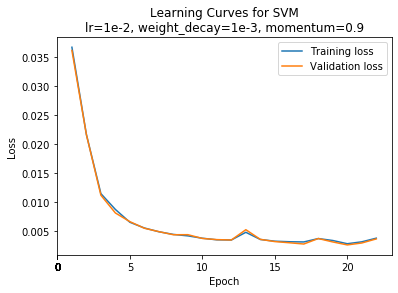

In [19]:
epochs = range(1, len(train_losses) + 1)
epoch_ticks = [i if i % 5 == 0 else 0 for i in epochs]
    
# plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, valid_losses, label='Validation loss')
plt.legend()
plt.title('Learning Curves for SVM\nlr=1e-2, weight_decay=1e-3, momentum=0.9')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.savefig("svm_train.jpg", dpi=300)
plt.show()

In [0]:
full_dataloader = get_dataloaders(dataset=DeepFakeHDF5Dataset(), full_dataset=True)

In [0]:
(x, y) = next(iter(full_dataloader))
print(x.shape)

torch.Size([40000, 725])


In [0]:
# Manual Standardization
from models import KMeans
mu = torch.mean(x, dim=1).unsqueeze(-1)
std = 1
X = (x.sub(other=mu))/std
cl, c = KMeans().run(X, K=2, Niter=50)

K-means example with 40,000 points in dimension 725, K = 2:
Timing for 50 iterations: 81.15923s = 50 x 1.62318s



In [0]:
print(cl.size())
print(c.size())
y = y.squeeze(-1).long()
print(y.size())
print(cl)
print(y)
sub = (cl - y)
print(sub)
print(sub.size())
print(cl == y)
accuracy = 1 - torch.mean((cl == y).float())
print("Accuracy: %f or %f " % (accuracy, (1-accuracy)))

torch.Size([40000])
torch.Size([2, 725])
torch.Size([40000])
tensor([0, 0, 1,  ..., 0, 1, 0])
tensor([1, 1, 0,  ..., 1, 0, 1])
tensor([-1, -1,  1,  ..., -1,  1, -1])
torch.Size([40000])
tensor([False, False, False,  ..., False, False, False])
Accuracy: 0.961000 or 0.039000 


In [0]:
# data
(x, y) = next(iter(full_dataloader))
data_size, dims, num_clusters = x.size(0), 2, 2
mu = torch.mean(x, dim=1).unsqueeze(-1)
std = 1
X = (x.sub(other=mu))/std
# kmeans
cluster_ids_x, cluster_centers = kmeans(
    X=X, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:0')
)

[running kmeans]: 0it [00:00, ?it/s]

running k-means on cuda:0..


[running kmeans]: 9it [00:01,  7.74it/s, center_shift=0.000000, iteration=9, tol=0.000100]


In [0]:

print(cluster_ids_x.size())
print(cluster_ids_x)
y = y.squeeze(-1).long()
accuracy = torch.mean((cluster_ids_x == y).float())
print("Accuracy: %f or %f " % (accuracy, (1-accuracy)))

torch.Size([40000])
tensor([1, 1, 0,  ..., 0, 0, 1])
Accuracy: 0.961000 or 0.039000 


In [0]:
from sklearn.cluster import KMeans
k = 2
kmeans = KMeans(n_clusters=k)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
Y = y.squeeze(-1).numpy()
print(Y.shape)
print(labels.shape)
res =labels+Y
cont=0
print(res.shape)
for z in range(len(res)):
    if res[z] == 1:
        cont+=1
print("Average KM: " + str(1-cont/len(res)) + " or " + str(cont/len(res)))

(40000,)
(40000,)
(40000,)
Average KM: 0.961 or 0.039


In [0]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle

# num = 5
# LR = 0
# SVM = 0
# SVM_r = 0
# SVM_p = 0


# for z in range(num):
#     # read python dict back from the file
#     data = None
#     lbls = None
#     og_d = None
#     with h5py.File(fhq_hdf5_pt, 'r') as hdf5_file: 
#         data = hdf5_file['fft_data'][:]
#         lbls = hdf5_file['lbl_data'][:]
#         og_d = hdf5_file['orgn_data'][:]

#     X = data 
#     y = lbls 


#     try:

#         from sklearn.model_selection import train_test_split
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#         from sklearn.svm import SVC
#         svclassifier = SVC(kernel='linear')
#         svclassifier.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
#         from sklearn.svm import SVC
#         svclassifier_r = SVC(C=3.1, kernel='rbf', gamma=0.00002)
#         svclassifier_r.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
#         from sklearn.svm import SVC
#         svclassifier_p = SVC(kernel='poly')
#         svclassifier_p.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
#         from sklearn.linear_model import LogisticRegression
#         logreg = LogisticRegression(solver='liblinear', max_iter=1000)
#         logreg.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
#         SVM+=svclassifier.score(X_test, y_test)
#         SVM_r+=svclassifier_r.score(X_test, y_test)
#         SVM_p+=svclassifier_p.score(X_test, y_test)
#         LR+=logreg.score(X_test, y_test)

 
#     except:
#         num-=1
#         print(num)
    
# print("Average SVM: "+str(SVM/num))
# print("Average SVM_r: "+str(SVM_r/num))
# print("Average SVM_p: "+str(SVM_p/num))
# print("Average LR: "+str(LR/num))